# Supplementary material

该文章为notes.psd中，已有、我提出的观点提供了一些例证。

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tqdm import tnrange, tqdm_notebook

import qchem

## 验证：RNN能够处理$[a,b]^{局域性}\to质量$

In [48]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5) # 正弦，自然是质量

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In [52]:
tf.reset_default_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print iteration, "\tMSE:", mse

0 	MSE: 16.491678
100 	MSE: 0.5802098
200 	MSE: 0.32238802
300 	MSE: 0.15436229
400 	MSE: 0.05665905
500 	MSE: 0.058811035
600 	MSE: 0.055063307
700 	MSE: 0.048686046
800 	MSE: 0.047912426
900 	MSE: 0.040929236
1000 	MSE: 0.040295158
1100 	MSE: 0.049605835
1200 	MSE: 0.050638612
1300 	MSE: 0.04592636
1400 	MSE: 0.045988332


##  提出并验证了：RNN并不完全能处理$[a,b]^{平等}\to数量$

In [ ]:
raw = []

for n_timesteps in tqdm_notebook(np.arange(3, 50, 3)):
    tf.reset_default_graph()

    # select the model
    n_instances = 1000
    n_timesteps = n_timesteps
    n_features = 1
    n_labels = 1
    hidden_RNNlayer_shape = 5

    n_epochs = 1000
    minibatch_size = None # batch gradient descent
    learning_rate = 0.01

    # get the data
    _X = np.random.rand(n_instances, n_timesteps, n_features) * 2 - 1
    _y = np.sum(_X, axis = 1)

    # graph
    X = tf.placeholder(name="X", shape=[None, n_timesteps, n_features], dtype=tf.float32)
    y = tf.placeholder(name="y", shape=[None, n_labels], dtype=tf.float32)
    hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.BasicRNNCell(hidden_RNNlayer_shape), X, dtype=tf.float32)
    yhat = tf.layers.dense(h, units=n_labels, activation=None, name="linear")

    loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
    train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

    # summary_op = tf.summary.scalar("loss", loss)

    # session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # filewriter = tf.summary.FileWriter('logs/tf.rnn_long_sum.size%s.'%n_timesteps + time.strftime("%Y%m%d%H%M%s"),
    #                                   tf.get_default_graph())
    for epoch in tnrange(n_epochs):
        sess.run(train_op, feed_dict={X: _X, y: _y})
        if epoch % 10 == 0:
            # filewriter.add_summary(sess.run(summary_op, feed_dict={X: _X, y: _y}), epoch)
            raw.append((n_timesteps, epoch, sess.run(loss, feed_dict={X: _X, y: _y})))
    # filewriter.close()
    sess.close()

In [18]:
df = pd.DataFrame(raw, columns=['n_timesteps', 'epoch', 'loss'])
df = df.set_index(['n_timesteps', 'epoch'])
df = df.unstack(level=0)

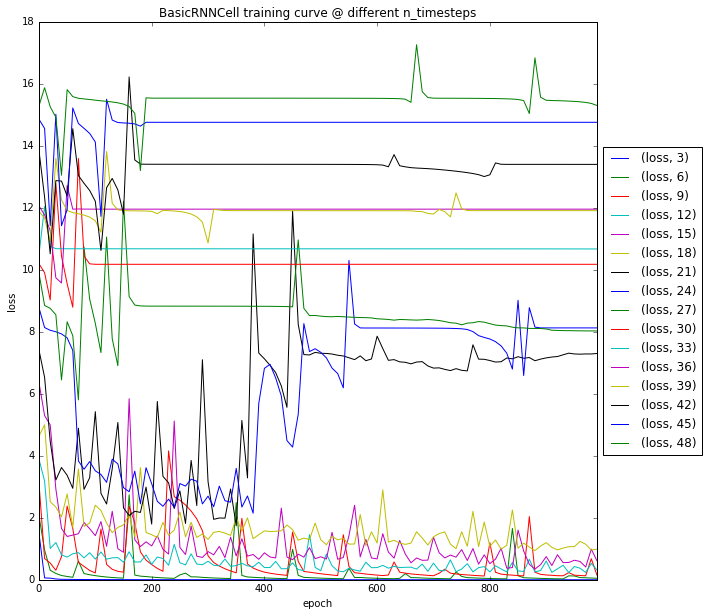

In [35]:
df.plot(figsize=(10,10), ax=plt.gca())
plt.title('BasicRNNCell training curve @ different n_timesteps')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
raw = []

for n_timesteps in tqdm_notebook(np.arange(3, 50, 3)):
    tf.reset_default_graph()

    # select the model
    n_instances = 1000
    n_timesteps = n_timesteps
    n_features = 1
    n_labels = 1
    hidden_RNNlayer_shape = 5

    n_epochs = 1000
    minibatch_size = None # batch gradient descent
    learning_rate = 0.01

    # get the data
    _X = np.random.rand(n_instances, n_timesteps, n_features) * 2 - 1
    _y = np.sum(_X, axis = 1)

    # graph
    X = tf.placeholder(name="X", shape=[None, n_timesteps, n_features], dtype=tf.float32)
    y = tf.placeholder(name="y", shape=[None, n_labels], dtype=tf.float32)
    chs, ch = tf.nn.dynamic_rnn(tf.contrib.rnn.BasicLSTMCell(hidden_RNNlayer_shape), X, dtype=tf.float32)
    yhat = tf.layers.dense(ch[0], units=n_labels, activation=None, name="linear")

    loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
    train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

    # summary_op = tf.summary.scalar("loss", loss)

    # session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # filewriter = tf.summary.FileWriter('logs/tf.lstm_long_sum.size%s.'%n_timesteps + time.strftime("%Y%m%d%H%M%s"),
    #                                   tf.get_default_graph())
    for epoch in tnrange(n_epochs, leave=False):
        sess.run(train_op, feed_dict={X: _X, y: _y})
        if epoch % 10 == 0:
            # filewriter.add_summary(sess.run(summary_op, feed_dict={X: _X, y: _y}), epoch)
            raw.append((n_timesteps, epoch, sess.run(loss, feed_dict={X: _X, y: _y})))
    # filewriter.close()
    sess.close()


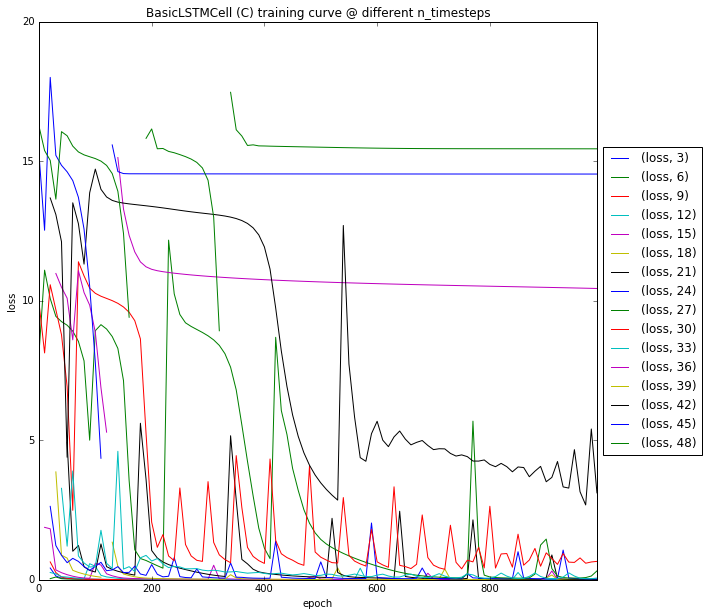

In [41]:
df = pd.DataFrame(raw, columns=['n_timesteps', 'epoch', 'loss'])
df = df.set_index(['n_timesteps', 'epoch'])
df = df.unstack(level=0)
df = df[np.abs(df.loss-df.loss.mean())<=(3*df.loss.std())]

df.plot(figsize=(10,10), ax=plt.gca())
plt.title('BasicLSTMCell (C) training curve @ different n_timesteps')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
raw = []

for n_timesteps in tqdm_notebook(np.arange(3, 50, 3)):
    tf.reset_default_graph()

    # select the model
    n_instances = 1000
    n_timesteps = n_timesteps
    n_features = 1
    n_labels = 1
    hidden_RNNlayer_shape = 5

    n_epochs = 1000
    minibatch_size = None # batch gradient descent
    learning_rate = 0.01

    # get the data
    _X = np.random.rand(n_instances, n_timesteps, n_features) * 2 - 1
    _y = np.sum(_X, axis = 1)

    # graph
    X = tf.placeholder(name="X", shape=[None, n_timesteps, n_features], dtype=tf.float32)
    y = tf.placeholder(name="y", shape=[None, n_labels], dtype=tf.float32)
    hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(hidden_RNNlayer_shape), X, dtype=tf.float32)
    yhat = tf.layers.dense(h, units=n_labels, activation=None, name="linear")

    loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
    train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

    # summary_op = tf.summary.scalar("loss", loss)

    # session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # filewriter = tf.summary.FileWriter('logs/tf.lstm_long_sum.size%s.'%n_timesteps + time.strftime("%Y%m%d%H%M%s"),
    #                                   tf.get_default_graph())
    for epoch in tnrange(n_epochs, leave=False):
        sess.run(train_op, feed_dict={X: _X, y: _y})
        if epoch % 10 == 0:
            # filewriter.add_summary(sess.run(summary_op, feed_dict={X: _X, y: _y}), epoch)
            raw.append((n_timesteps, epoch, sess.run(loss, feed_dict={X: _X, y: _y})))
    # filewriter.close()
    sess.close()

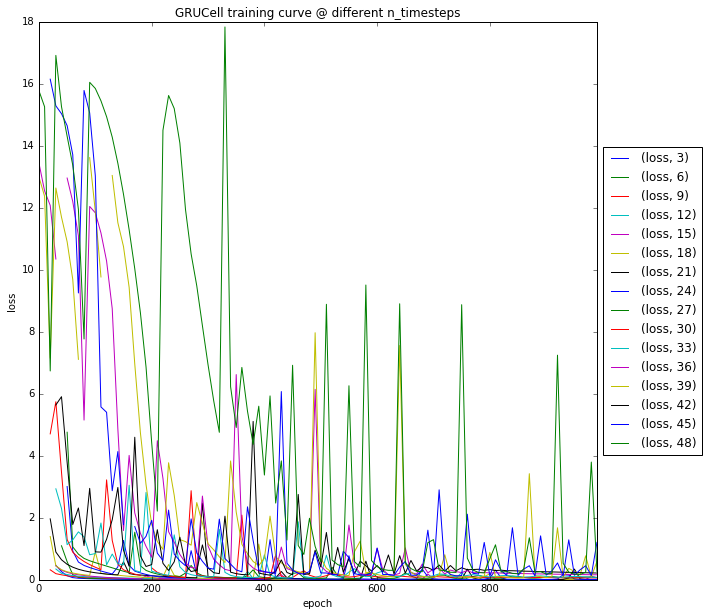

In [43]:
df = pd.DataFrame(raw, columns=['n_timesteps', 'epoch', 'loss'])
df = df.set_index(['n_timesteps', 'epoch'])
df = df.unstack(level=0)
df = df[np.abs(df.loss-df.loss.mean())<=(3*df.loss.std())]

df.plot(figsize=(10,10), ax=plt.gca())
plt.title('GRUCell training curve @ different n_timesteps')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
!trash logs/*

In [ ]:
raw = []

for n_timesteps in tqdm_notebook(np.arange(50, 500, 20), leave=False):
    tf.reset_default_graph()

    # select the model
    n_instances = 1000
    n_timesteps = n_timesteps
    n_features = 1
    n_labels = 1
    hidden_RNNlayer_shape = 5

    n_epochs = 1000
    minibatch_size = None # batch gradient descent
    learning_rate = 0.01

    # get the data
    _X = np.random.rand(n_instances, n_timesteps, n_features) * 2 - 1
    _y = np.sum(_X, axis = 1)

    # graph
    X = tf.placeholder(name="X", shape=[None, n_timesteps, n_features], dtype=tf.float32)
    y = tf.placeholder(name="y", shape=[None, n_labels], dtype=tf.float32)
    hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(hidden_RNNlayer_shape), X, dtype=tf.float32)
    yhat = tf.layers.dense(h, units=n_labels, activation=None, name="linear")

    loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
    train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)

    # summary_op = tf.summary.scalar("loss", loss)

    # session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # filewriter = tf.summary.FileWriter('logs/tf.lstm_long_sum.size%s.'%n_timesteps + time.strftime("%Y%m%d%H%M%s"),
    #                                   tf.get_default_graph())
    for epoch in tnrange(n_epochs, leave=False):
        sess.run(train_op, feed_dict={X: _X, y: _y})
        if epoch % 10 == 0:
            # filewriter.add_summary(sess.run(summary_op, feed_dict={X: _X, y: _y}), epoch)
            raw.append((n_timesteps, epoch, sess.run(loss, feed_dict={X: _X, y: _y})))
    # filewriter.close()
    sess.close()

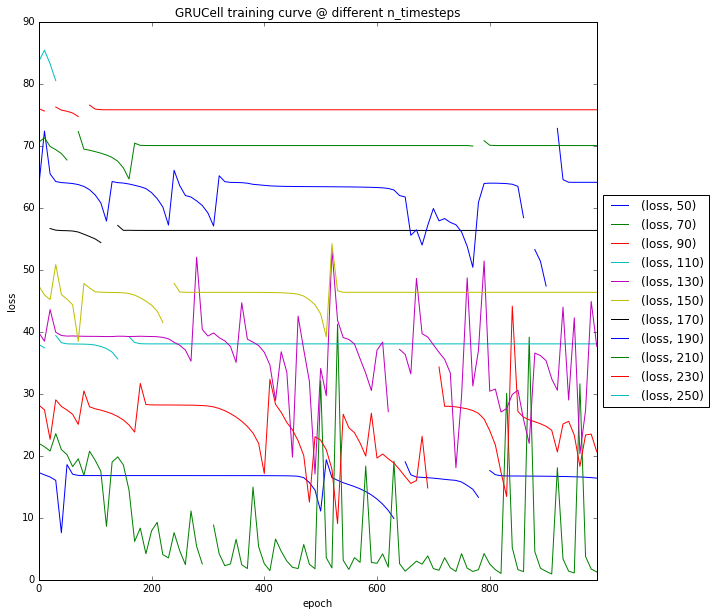

In [45]:
df = pd.DataFrame(raw, columns=['n_timesteps', 'epoch', 'loss'])
df = df.set_index(['n_timesteps', 'epoch'])
df = df.unstack(level=0)
df = df[np.abs(df.loss-df.loss.mean())<=(3*df.loss.std())]

df.plot(figsize=(10,10), ax=plt.gca())
plt.title('GRUCell training curve @ different n_timesteps')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## 提出并验证：AdamOptimizer是如此改善收敛，它能使不收敛的收敛

情形：$[a,b]^{平等}\to数量$，GRU Cell.

首先是Momentum Optimizer。

In [ ]:
!trash logs/*

In [ ]:
raw = []

for n_timesteps in tqdm_notebook(np.arange(10, 120, 20), leave=False):
    tf.reset_default_graph()

    # select the model
    n_instances = 1000
    n_timesteps = n_timesteps
    n_features = 1
    n_labels = 1
    hidden_RNNlayer_shape = 5

    n_epochs = 1000
    minibatch_size = None # batch gradient descent
    learning_rate = 0.005

    # get the data
    _X = np.random.rand(n_instances, n_timesteps, n_features) * 2 - 1 # [a,b]
    _y = np.sum(_X, axis = 1) # [平等；数量]

    # graph
    X = tf.placeholder(name="X", shape=[None, n_timesteps, n_features], dtype=tf.float32)
    y = tf.placeholder(name="y", shape=[None, n_labels], dtype=tf.float32)
    hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(hidden_RNNlayer_shape), X, dtype=tf.float32)
    yhat = tf.layers.dense(h, units=n_labels, activation=None, name="linear") # 输出转换层，属于典型技术

    loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
    train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)
    # train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    summary_op = tf.summary.scalar("loss", loss)

    # session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    filewriter = tf.summary.FileWriter('logs/tf.lstm_long_sum.size%s.'%n_timesteps + time.strftime("%Y%m%d%H%M%s"),
                                      tf.get_default_graph())
    for epoch in tnrange(n_epochs, leave=False):
        sess.run(train_op, feed_dict={X: _X, y: _y})
        if epoch % 10 == 0:
            filewriter.add_summary(sess.run(summary_op, feed_dict={X: _X, y: _y}), epoch)
            raw.append((n_timesteps, epoch, sess.run(loss, feed_dict={X: _X, y: _y})))
    filewriter.close()
    sess.close()

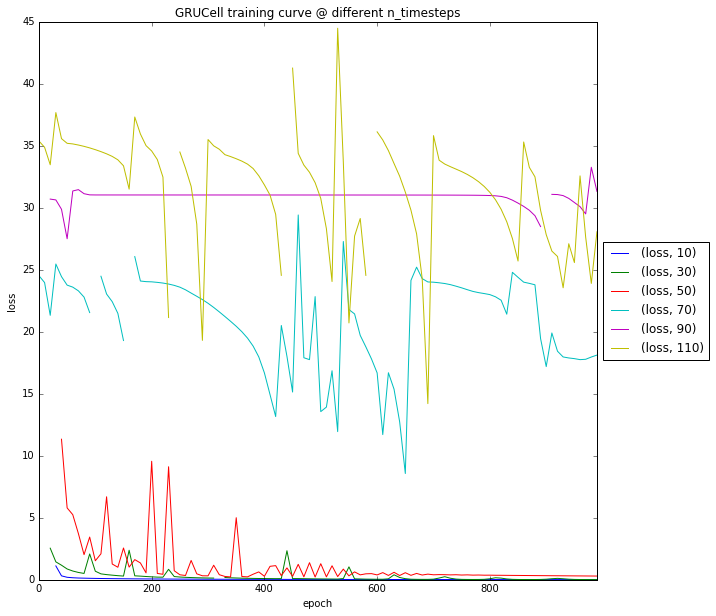

In [57]:
df = pd.DataFrame(raw, columns=['n_timesteps', 'epoch', 'loss'])
df = df.set_index(['n_timesteps', 'epoch'])
df = df.unstack(level=0)
df = df[np.abs(df.loss-df.loss.mean())<=(3*df.loss.std())]

df.plot(figsize=(10,10), ax=plt.gca())
plt.title('GRUCell training curve @ different n_timesteps')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

同样情况（略）甚至更高learning_rate，AdamOptimizer:

In [ ]:
!trash logs/*

In [ ]:
raw = []

for n_timesteps in tqdm_notebook(np.arange(10, 120, 20), leave=False):
    tf.reset_default_graph()

    # select the model
    n_instances = 1000
    n_timesteps = n_timesteps
    n_features = 1
    n_labels = 1
    hidden_RNNlayer_shape = 5

    n_epochs = 1000
    minibatch_size = None # batch gradient descent
    learning_rate = 0.01

    # get the data
    _X = np.random.rand(n_instances, n_timesteps, n_features) * 2 - 1 # [a,b]
    _y = np.sum(_X, axis = 1) # [平等；数量]

    # graph
    X = tf.placeholder(name="X", shape=[None, n_timesteps, n_features], dtype=tf.float32)
    y = tf.placeholder(name="y", shape=[None, n_labels], dtype=tf.float32)
    hs, h = tf.nn.dynamic_rnn(tf.contrib.rnn.GRUCell(hidden_RNNlayer_shape), X, dtype=tf.float32)
    yhat = tf.layers.dense(h, units=n_labels, activation=None, name="linear") # 输出转换层，属于典型技术

    loss = tf.reduce_mean(tf.square(yhat - y), keepdims=False)
    # train_op = tf.train.MomentumOptimizer(learning_rate, momentum=0.9, use_nesterov=True).minimize(loss)
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    summary_op = tf.summary.scalar("loss", loss)

    # session
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    filewriter = tf.summary.FileWriter('logs/tf.lstm_long_sum.size%s.'%n_timesteps + time.strftime("%Y%m%d%H%M%s"),
                                      tf.get_default_graph())
    for epoch in tnrange(n_epochs, leave=False):
        sess.run(train_op, feed_dict={X: _X, y: _y})
        if epoch % 10 == 0:
            filewriter.add_summary(sess.run(summary_op, feed_dict={X: _X, y: _y}), epoch)
            raw.append((n_timesteps, epoch, sess.run(loss, feed_dict={X: _X, y: _y})))
    filewriter.close()
    sess.close()

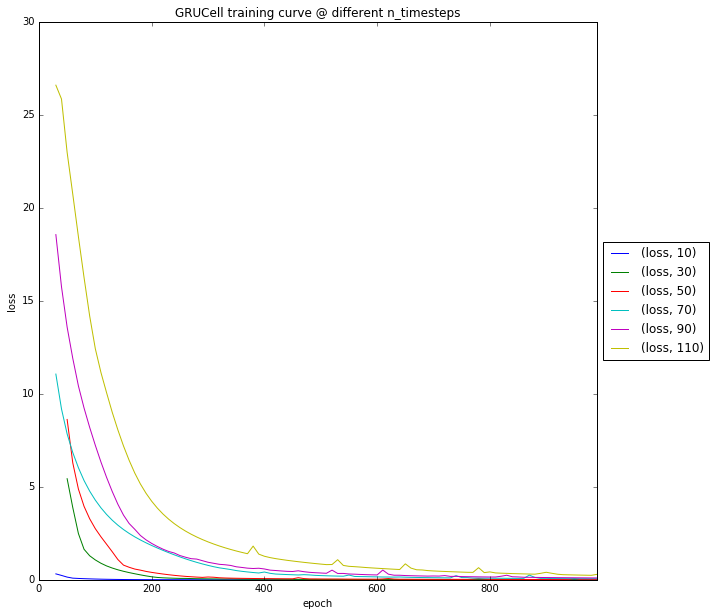

In [65]:
df = pd.DataFrame(raw, columns=['n_timesteps', 'epoch', 'loss'])
df = df.set_index(['n_timesteps', 'epoch'])
df = df.unstack(level=0)
df = df[np.abs(df.loss-df.loss.mean())<=(3*df.loss.std())]

df.plot(figsize=(10,10), ax=plt.gca())
plt.title('GRUCell training curve @ different n_timesteps')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()